Import all the neccessary Libraries

In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 75.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import os


In [3]:
cyclone_path_data = '/content/drive/MyDrive/Old_Cyclone_path_data/ibtracs_Data_Old_Cyclones.csv'


In [4]:
Cyclone_df = pd.read_csv(cyclone_path_data)

/tmp/ipython-input-1336836475.py:1: DtypeWarning: Columns (1,2,8,9,14,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  Cyclone_df = pd.read_csv(cyclone_path_data)


In [ ]:
print(Cyclone_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62049 entries, 0 to 62048
Columns: 174 entries, SID to STORM_DIR
dtypes: int64(1), object(173)
memory usage: 82.4+ MB
None


In [5]:
df = Cyclone_df[(Cyclone_df["LAT"].notna()) & (Cyclone_df["LON"].notna())]
df = df[1:]
df[["LAT","LON"]]=df[["LAT","LON"]].astype(np.float32)


# Bay of Bengal bounding box
bengal_mask = df[(df["LAT"] >= 5) & (df["LAT"] <= 25) &
            (df["LON"] >= 80) & (df["LON"] <= 100)]

bengal_mask[["SID", "NAME", "ISO_TIME", "LAT", "LON", "WMO_WIND", "WMO_PRES"]]

,SID,NAME,ISO_TIME,LAT,LON,WMO_WIND,WMO_PRES
1,1842298N11080,UNNAMED,1842-10-25 03:00:00,10.9,80.300003,,
116,1877135N10083,UNNAMED,1877-05-15 00:00:00,9.9,82.900002,,
117,1877135N10083,UNNAMED,1877-05-15 03:00:00,10.0,82.800003,,
118,1877135N10083,UNNAMED,1877-05-15 06:00:00,10.1,82.699997,,
119,1877135N10083,UNNAMED,1877-05-15 09:00:00,10.2,82.599998,,
...,...,...,...,...,...,...,...
62021,2024335N12082,FENGAL,2024-11-30 15:00:00,12.3,80.400002,,
62022,2024335N12082,FENGAL,2024-11-30 18:00:00,12.2,80.199997,,
62023,2024335N12082,FENGAL,2024-11-30 21:00:00,12.1,80.099998,,
62024,2024335N12082,FENGAL,2024-12-01 00:00:00,12.1,80.000000,,


In [6]:
bengal_mask["CYCLONE_FLAG"] = 1

# Convert ISO_TIME column to datetime
bengal_mask["ISO_TIME"] = pd.to_datetime(bengal_mask["ISO_TIME"], errors="coerce")

# Now extract only the date part
bengal_mask["DATE"] = bengal_mask["ISO_TIME"].dt.date

# Group by DATE and get max CYCLONE_FLAG (1 if cyclone present that day)
daily_labels = bengal_mask.groupby("DATE")["CYCLONE_FLAG"].max().reset_index()

print(daily_labels.head())

         DATE  CYCLONE_FLAG
0  1842-10-25             1
1  1877-05-15             1
2  1877-05-16             1
3  1877-05-17             1
4  1877-05-18             1


/tmp/ipython-input-2209993903.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bengal_mask["CYCLONE_FLAG"] = 1
/tmp/ipython-input-2209993903.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bengal_mask["ISO_TIME"] = pd.to_datetime(bengal_mask["ISO_TIME"], errors="coerce")
/tmp/ipython-input-2209993903.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [7]:
Image_data = []
Labels = []
Dates = []
for file in os.listdir(path):
    y = int(file.split('_')[1].split('.')[0])
    with rasterio.open(path+"/"+file) as src:
        print(f"working for File : {file}")
        data = src.read()
        profile = src.profile
        H, W = src.height, src.width

    # leap year check
    days = 366 if (y % 4 == 0) else 365
    bands = 6

    reshaped_data = data.reshape(days, bands, H, W)

    # generate date index for that year
    dates = pd.date_range(f"{y}-01-01", periods=days, freq="D")

    # align X (features) and Y (labels)
    for day_idx, date in enumerate(dates):
        date_only = date.date()
        X = reshaped_data[day_idx]   # shape (6, H, W)

        # get cyclone label (0 if not cyclone, 1 if cyclone)
        if date_only in set(daily_labels["DATE"].values):
            y_label = 1
        else:
            y_label = 0

        Image_data.append(X)
        Labels.append(y_label)

    print(f"Conversion successful for File : {file}")

# Final arrays
X = np.array(Image_data)   # (total_days, 6, H, W)
Y = np.array(Labels)       # (total_days,)

NameError: name 'path' is not defined

In [ ]:
X.shape

(5479, 6, 224, 168)

In [ ]:
X = np.save('/content/drive/MyDrive/CyclonePredictionDataPrep/Features_data.npy',X)


In [ ]:
Y = np.load('/content/drive/MyDrive/CyclonePredictionDataPrep/Label_data.npy')

In [ ]:
print("Cyclone days : ",sum(Y))

Cyclone days :  431


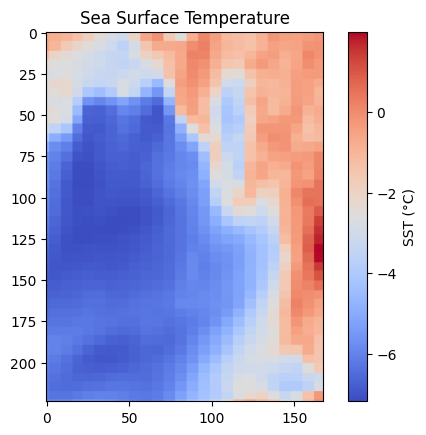

In [ ]:
img = X[1][2]
plt.imshow(img, cmap="coolwarm")
plt.colorbar(label="SST (°C)")
plt.title("Sea Surface Temperature")
plt.show()